# 🧠 Taller: *Análisis y Predicción del Consumo Energético con Series Temporales*

**Duración:** 1 hora  
**Herramientas:** Python (Pandas, Statsmodels, Scikit-learn, Matplotlib)  
**Objetivo:** aprender a analizar y predecir la demanda eléctrica, comparando modelos clásicos y de *machine learning*, e incorporar costos reales de sobre/subestimación.

In [4]:
# === Librerías base ===
# Instalar si hace falta:
# !pip install numpy pandas matplotlib scikit-learn statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

## ⚡ ¿Por qué importa pronosticar la demanda?

> Las empresas de energía deben equilibrar **oferta y demanda** cada hora.  
> - Si generan o compran de más → pérdidas por venta barata  
> - Si generan o compran de menos → cortes o energía de emergencia a precios altísimos  

Una buena predicción significa **millones en ahorro operativo** y decisiones informadas sobre cuándo **generar, comprar o vender** energía.

📈 **Nuestro objetivo hoy:**  
Usar datos horarios de demanda eléctrica (reales o simulados) para:
1. Analizar patrones y estacionalidades.  
2. Probar dos métodos predictivos: **ARIMA** vs **Random Forest**.  
3. Evaluar errores y **costos asimétricos**.

## 🧩 Cargar los datos

In [10]:
# --- Cargar el dataset previamente generado ---
data = pd.read_csv("synthetic_energy_demand_with_covariates.csv", parse_dates=["timestamp"])
data.set_index("timestamp", inplace=True)
data.head()

,subregion,temp_c,humidity_pct,demanda_mwh,hour,dow,month,holiday
timestamp,,,,,,,,
2020-01-01 00:00:00,Norte,11.195193,96.912983,92.021472,0,2,1,1
2020-01-01 01:00:00,Norte,14.859958,86.646666,166.795309,1,2,1,1
2020-01-01 02:00:00,Norte,15.824377,86.669321,191.872985,2,2,1,1
2020-01-01 03:00:00,Norte,18.501837,76.085419,212.770663,3,2,1,1
2020-01-01 04:00:00,Norte,16.621752,77.909265,218.678552,4,2,1,1


In [12]:
# Información general del dataset
print(data.info())
print("\nRango de fechas:", data.index.min(), "→", data.index.max())
print("\nSubregiones disponibles:", data["subregion"].unique())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131400 entries, 2020-01-01 00:00:00 to 2022-12-30 23:00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   subregion     131400 non-null  object 
 1   temp_c        131400 non-null  float64
 2   humidity_pct  131400 non-null  float64
 3   demanda_mwh   131400 non-null  float64
 4   hour          131400 non-null  int64  
 5   dow           131400 non-null  int64  
 6   month         131400 non-null  int64  
 7   holiday       131400 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 9.0+ MB
None

Rango de fechas: 2020-01-01 00:00:00 → 2022-12-30 23:00:00

Subregiones disponibles: ['Norte' 'Centro' 'Sur' 'Occidente' 'Oriente']


## 🔍 Exploración de Datos (EDA)

Vamos a explorar cómo varía la **demanda eléctrica** a lo largo del tiempo y entre diferentes subregiones,  
para identificar patrones estacionales y diferencias en el comportamiento del consumo.

### 📊 Ejemplo: Demanda promedio mensual por subregión
Agrupemos la demanda promedio **mensual** por **subregión** para observar tendencias y posibles estacionalidades a lo largo del año.


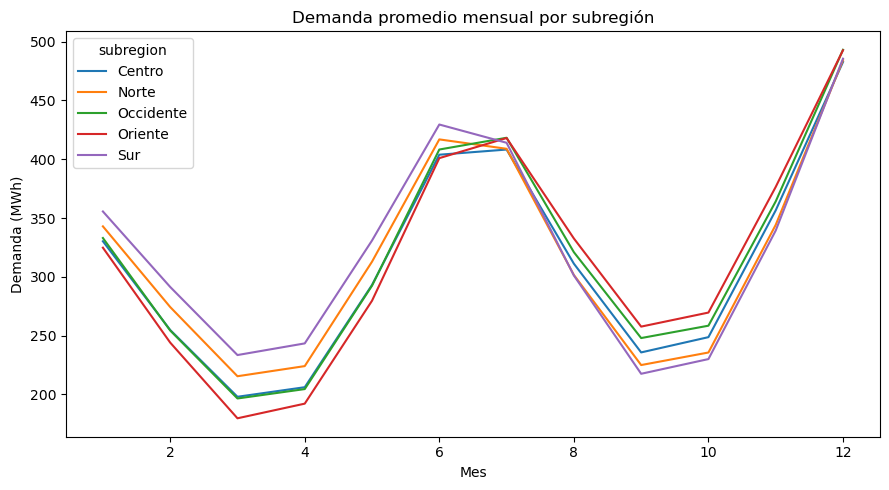

In [16]:
# --- Perfil mensual promedio ---
fig, ax = plt.subplots(figsize=(9, 5))
tmp_month = data.groupby(["subregion", data.index.month])["demanda_mwh"].mean().unstack(0)
tmp_month.plot(ax=ax)
ax.set_title("Demanda promedio mensual por subregión")
ax.set_xlabel("Mes")
ax.set_ylabel("Demanda (MWh)")
plt.tight_layout()
plt.show()

👀 **Observación:**  
Se nota un patrón estacional: algunos meses (por ejemplo, verano o invierno) presentan una mayor demanda según la región.

---

### 🧩 Ejercicio para la audiencia

💭 **Pregunta:**  
¿Qué pasaría si en lugar de agrupar por *mes*, agrupamos por *día de la semana*?

👉 **Tu turno:** agrupa los datos para calcular la demanda promedio por día de la semana (0=Lunes, 6=Domingo) y genera un gráfico similar al anterior.

*(Tómate un momento para pensar cómo cambiarías el código...)*


### ✅ Solución

En lugar de `data.index.month`, podemos usar `data.index.dayofweek` (o una columna auxiliar `dow`) para agrupar por día de la semana.

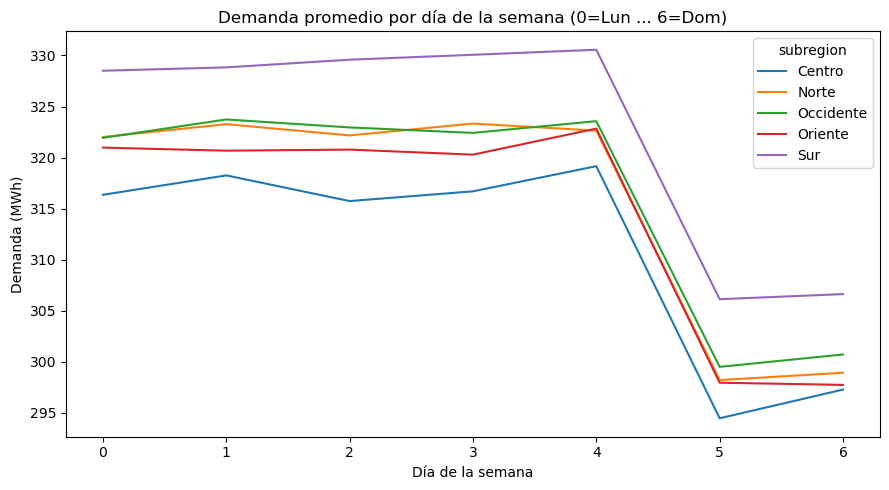

In [22]:
# --- Solución: Demanda promedio por día de la semana ---
fig, ax = plt.subplots(figsize=(9, 5))
tmp_dow = (data
           .assign(dow=data.index.dayofweek)
           .groupby(["subregion", "dow"])["demanda_mwh"]
           .mean()
           .unstack(0))
tmp_dow.plot(ax=ax)
ax.set_title("Demanda promedio por día de la semana (0=Lun ... 6=Dom)")
ax.set_xlabel("Día de la semana")
ax.set_ylabel("Demanda (MWh)")
plt.tight_layout()
plt.show()

💡 **Conclusión del ejercicio:**  
El patrón semanal suele mostrar menor consumo durante los fines de semana (días 5 y 6), cuando la actividad industrial disminuye.

👉 Esta variación es importante al construir modelos, porque nos indica que debemos incluir la variable `day_of_week` o `dow` como **covariable temporal**.

## 🌦️ Relación entre Variables Climáticas y DemandaLas condiciones meteorológicas influyen directamente en el consumo energético. 
Primero analizaremos cómo la **temperatura** se correlaciona con la demanda,  y luego haremos un ejercicio con la **humedad**.

subregion
Centro      -0.078930
Norte       -0.009235
Occidente   -0.104108
Oriente     -0.160721
Sur          0.039400
Name: corr_temp_demanda, dtype: float64

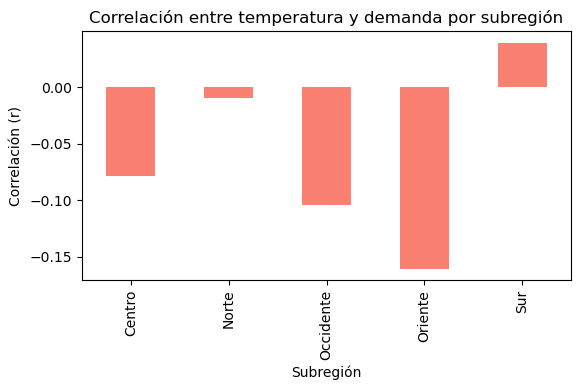

In [27]:
# --- Demostración: Correlación temperatura-demanda ---
corr_temp = (
    data.groupby("subregion")
    .apply(lambda g: g["temp_c"].corr(g["demanda_mwh"]))
    .rename("corr_temp_demanda")
)

display(corr_temp)

fig, ax = plt.subplots(figsize=(6,4))
corr_temp.plot(kind="bar", color="salmon", ax=ax)
ax.set_title("Correlación entre temperatura y demanda por subregión")
ax.set_xlabel("Subregión")
ax.set_ylabel("Correlación (r)")
plt.tight_layout()
plt.show()

👀 **Observación:**  
- Una correlación positiva indica que a mayor temperatura, aumenta la demanda (por aire acondicionado).  
- Una correlación negativa sugiere lo contrario (por calefacción en climas fríos).

### 🧩 Ejercicio para la audiencia

💭 **Pregunta:**  
¿Y qué sucede con la **humedad** (`humidity_pct`)?  

👉 Calcula la correlación entre `humidity_pct` y `demanda_mwh` para cada subregión.  
Usa el mismo enfoque que en el ejemplo anterior (`groupby` + `apply` + `corr`).

*(Tómate un momento para intentarlo...)*

### ✅ Solución

Solo cambiamos la columna de temperatura por la de humedad y repetimos el mismo análisis.

subregion
Centro       0.215432
Norte        0.160098
Occidente    0.236162
Oriente      0.284691
Sur          0.120879
Name: corr_humedad_demanda, dtype: float64

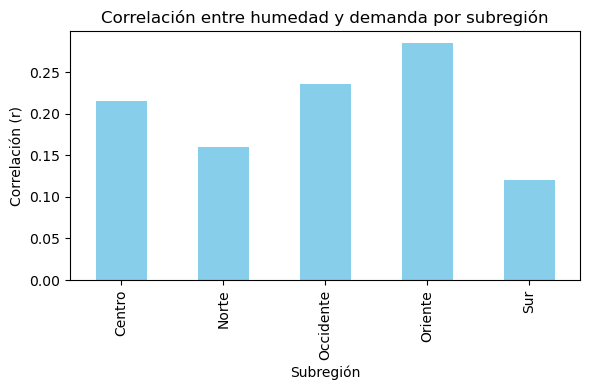

In [32]:
# --- Solución: Correlación humedad-demanda ---
corr_hum = (
    data.groupby("subregion")
    .apply(lambda g: g["humidity_pct"].corr(g["demanda_mwh"]))
    .rename("corr_humedad_demanda")
)

display(corr_hum)

fig, ax = plt.subplots(figsize=(6,4))
corr_hum.plot(kind="bar", color="skyblue", ax=ax)
ax.set_title("Correlación entre humedad y demanda por subregión")
ax.set_xlabel("Subregión")
ax.set_ylabel("Correlación (r)")
plt.tight_layout()
plt.show()

## 💡 **Conclusión del ejercicio**

- Una **correlación positiva** entre la demanda y la humedad puede reflejar que el **aire cálido y húmedo incrementa el uso de sistemas de refrigeración**, elevando el consumo energético.  
- En cambio, una **correlación negativa** puede indicar regiones donde la **humedad coincide con temperaturas más bajas**, reduciendo la necesidad de climatización.  

👉 Analizar conjuntamente **temperatura y humedad** permite identificar **qué variable explica mejor las variaciones en la demanda eléctrica** y cómo estas relaciones cambian según las condiciones climáticas de cada subregión.


## 🤖 Modelos para pronosticar

Ahora que comprendemos el comportamiento general de la demanda, pasemos a los **modelos de predicción**.  
En esta sección exploraremos dos enfoques complementarios: uno **clásico estadístico** y otro **basado en aprendizaje automático**.

---

### 🔹 Modelo SARIMAX (clásico de series temporales)

El modelo **SARIMAX** (*Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors*) combina los fundamentos del modelo ARIMA con la posibilidad de incorporar variables externas (*exógenas*), como la temperatura.

**Características principales:**
- Se basa en la **dependencia temporal**: la demanda actual depende de los valores pasados.  
- Captura **patrones estacionales** (por ejemplo, ciclos diarios o semanales).  
- Permite incluir **variables externas** que afectan la demanda, como temperatura, humedad o eventos.  

**Componentes del modelo:**
- **AR (AutoRegresivo):** usa valores pasados para predecir el presente.  
- **I (Integrado):** diferencia los datos para hacerlos estacionarios.  
- **MA (Media Móvil):** modela la estructura de error residual.  
- **S (Estacional):** añade un componente periódico (por ejemplo, 24 h en datos horarios).  

**Cuándo usar SARIMAX:**
- Cuando trabajamos con **una sola serie temporal** (por ejemplo, una subregión específica).  
- Cuando queremos **entender la dinámica interna** del consumo y el efecto de variables exógenas.  

💡 **En resumen:**  
SARIMAX es un modelo interpretativo y sólido para estudiar el comportamiento temporal de la demanda eléctrica en una región concreta, especialmente útil cuando los patrones estacionales y los factores externos tienen un papel claro.


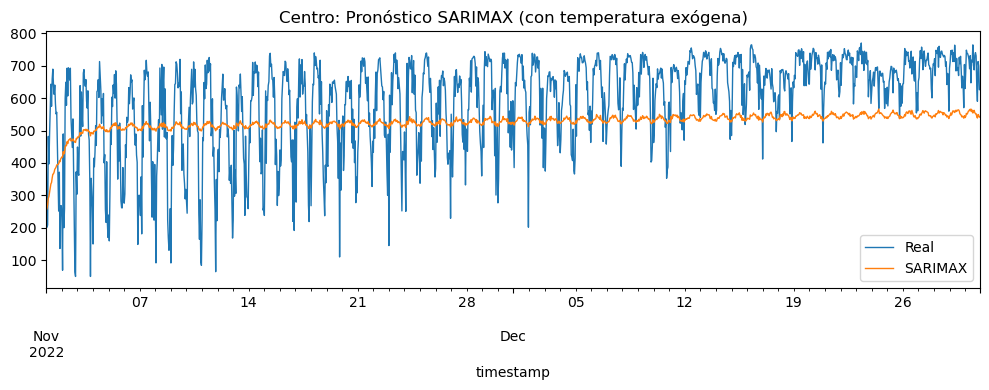

In [45]:
# --- SARIMAX: entrenar en una subregión ---
sr_ejemplo = "Centro"
df_sr = data.loc[data["subregion"] == sr_ejemplo, ["demanda_mwh", "temp_c"]].copy()

# --- Separar entrenamiento y prueba ---
# Usaremos los últimos 60 días (~1440 horas) como conjunto de prueba.
test_horas = 24 * 60
y = df_sr["demanda_mwh"]
exog = df_sr[["temp_c"]]
y_train, y_test = y.iloc[:-test_horas], y.iloc[-test_horas:]
X_train, X_test = exog.iloc[:-test_horas], exog.iloc[-test_horas:]

# --- Entrenar modelo SARIMAX ---
# Parámetros básicos:
# (p,d,q) = (1,0,1): estructura autoregresiva (AR) y de medias móviles (MA) simple.
# 'trend="t"' agrega una tendencia lineal al modelo, útil cuando la demanda crece con el tiempo.
# 'exog=X_train' incluye una variable exógena (temperatura) que también influye en la demanda.

sarimax = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 0, 1),    # modelo ARMA simple
    trend="t"           # añade tendencia lineal para seguir la dirección ascendente
)

# Entrenamiento del modelo (maxiter controla el número de iteraciones del optimizador)
res = sarimax.fit(disp=False, maxiter=50)

# --- Predicción en el conjunto de prueba ---
pred_sarimax = res.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

# --- Visualización ---
fig, ax = plt.subplots(figsize=(10, 4))
y_test.plot(ax=ax, label="Real", linewidth=1)
pred_sarimax.plot(ax=ax, label="SARIMAX", linewidth=1)
ax.set_title(f"{sr_ejemplo}: Pronóstico SARIMAX (con temperatura exógena)")
ax.legend()
plt.tight_layout()
plt.show()

## 🔎 **Interpretación**

- El modelo **SARIMAX** capta los **patrones cíclicos** y las **tendencias estacionales** de la demanda, ajustándolos en función de variables externas como la temperatura.  
- En contextos donde la temperatura influye fuertemente en el consumo energético, este enfoque suele **superar al modelo ARIMA tradicional**, ya que incorpora información exógena relevante.  
- No obstante, **SARIMAX se entrena por separado en cada subregión**, lo que puede limitar su capacidad de **generalizar comportamientos** cuando existen múltiples zonas con dinámicas distintas.

💡 **En resumen:**  
SARIMAX es ideal para analizar zonas específicas con patrones bien definidos, pero puede quedarse corto frente a métodos más flexibles cuando se busca modelar sistemas energéticos complejos y heteroéneos.


### 🔹 Random Forest (*machine learning*)

El modelo **Random Forest Regressor** pertenece a la familia de algoritmos de *machine learning* basados en **múltiples árboles de decisión**.  
Cada árbol aprende de una muestra diferente de los datos y el modelo final combina sus resultados, generando un pronóstico más estable y robusto.

**Características principales:**

- No asume **linealidad** ni **estacionalidad explícita** en los datos.  
- Aprende de múltiples **variables predictoras** simultáneamente, como:
  - Temperatura  
  - Humedad  
  - Día de la semana  
  - Hora del día  
  - Rezagos de la demanda (valores históricos)  
- Puede entrenarse de forma conjunta en **varias subregiones**, aprovechando patrones comunes en distintas zonas.

💡 **En resumen:**  
Random Forest ofrece una alternativa flexible y poderosa frente a los modelos estadísticos clásicos, especialmente útil cuando la relación entre las variables no es lineal o es difícil de modelar con ecuaciones tradicionales.


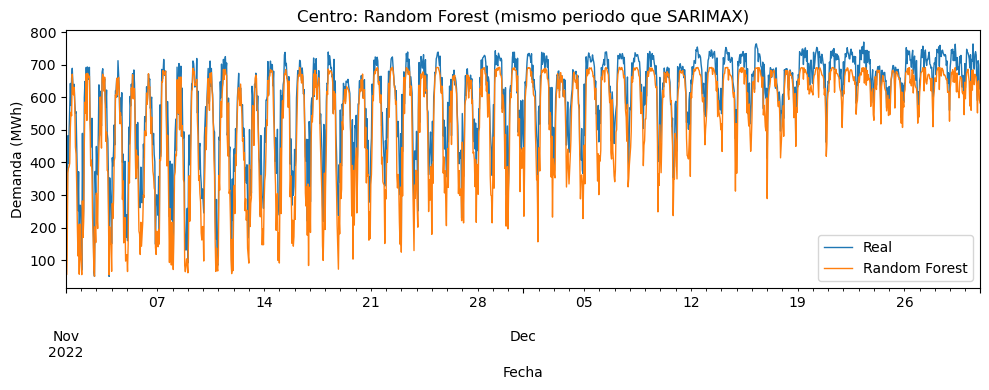

In [67]:
# --- Funciones auxiliares ---
def add_time_features(df):
    """Agrega variables de calendario básicas."""
    df = df.copy()
    df["hour"] = df.index.hour
    df["dow"] = df.index.dayofweek
    df["month"] = df.index.month
    return df

def add_lags(df, target_col="demanda_mwh", lags=(1, 2, 24, 48, 168)):
    """Agrega rezagos de la variable objetivo para capturar memoria temporal."""
    df = df.copy()
    for L in lags:
        df[f"{target_col}_lag{L}"] = df[target_col].shift(L)
    return df

# %%
# --- Preparar datos ---
panel = data.copy()
panel = panel.groupby("subregion", group_keys=False).apply(add_time_features)
panel = panel.groupby("subregion", group_keys=False).apply(add_lags)
panel = panel.dropna()

# --- División temporal ---
cut_idx = panel.index.max() - pd.Timedelta(hours=test_horas)
train = panel.loc[panel.index <= cut_idx]
test  = panel.loc[panel.index > cut_idx]

# --- Variables predictoras y objetivo ---
features = [c for c in panel.columns if c not in ["demanda_mwh", "subregion"]]
Xtr, Xte = train[features], test[features]
ytr, yte = train["demanda_mwh"], test["demanda_mwh"]

# --- Entrenar modelo ---
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr, ytr)

# --- Predicciones ---
pred_rf = pd.Series(rf.predict(Xte), index=Xte.index)

# --- Filtrar y mostrar la misma subregión que el SARIMAX ---
sr_ejemplo = "Centro"
mask_sr = test["subregion"] == sr_ejemplo
yte_sr = yte[mask_sr]
prf_sr = pred_rf[mask_sr]

# --- Alinear fechas con SARIMAX ---
yte_sr = yte_sr.loc[y_test.index.intersection(yte_sr.index)]
prf_sr = prf_sr.loc[yte_sr.index]

# --- Visualización ---
fig, ax = plt.subplots(figsize=(10, 4))
yte_sr.plot(ax=ax, label="Real", linewidth=1)
prf_sr.plot(ax=ax, label="Random Forest", linewidth=1)
ax.set_title(f"{sr_ejemplo}: Random Forest (mismo periodo que SARIMAX)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Demanda (MWh)")
ax.legend()
plt.tight_layout()
plt.show()

# En general:
- **SARIMAX** → más interpretable, mejor para una sola serie.  
- **Random Forest** → más flexible, mejor para datos con muchos factores y regiones.
---

# 🔎 **Interpretación:**
 - Random Forest aprende patrones no lineales y combina muchas fuentes de información (hora, día, temperatura, lags...).  
 - Como el modelo se entrena con todas las subregiones al mismo tiempo, puede aprender **tendencias generales** del sistema.  
 - No necesita datos estacionarios ni suposiciones estadísticas estrictas como ARIMA/SARIMAX.  
 - Sin embargo, pierde algo de **interpretabilidad**, ya que es más difícil saber exactamente *por qué* predice un valor específico.

---

💡 
En la práctica, ambos modelos pueden complementarse:  
SARIMAX es ideal para análisis profundo de una serie individual, mientras que Random Forest (o modelos de ML más complejos) pueden capturar relaciones globales y no lineales.

---
 

## 📏 Métricas de Evaluación

Una vez obtenidas las predicciones, necesitamos medir qué tan bien lo hizo cada modelo.  
En predicción de demanda energética, las métricas más comunes son las siguientes:

---

### 🔹 **RMSE — Root Mean Squared Error**

Mide el error cuadrático medio y penaliza fuertemente los errores grandes:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

- \( y_i \): valor real  
- \( \hat{y}_i \): valor predicho  
- \( n \): número de observaciones  

🧠 **Interpretación:** cuanto menor el RMSE, mejor el ajuste.  
Penaliza más los errores grandes (por el cuadrado).

---

### 🔹 **MAE — Mean Absolute Error**

Promedio del valor absoluto de los errores. Es más robusto ante valores extremos:

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

🧠 **Interpretación:** representa el error promedio en unidades de la variable (por ejemplo, MWh).  
Más fácil de interpretar que el RMSE, pero menos sensible a errores grandes.

---

### 🔹 **MAPE — Mean Absolute Percentage Error**

Expresa el error promedio como porcentaje del valor real:

$$
MAPE = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

🧠 **Interpretación:** útil para comparar modelos entre subregiones o escalas diferentes,  
ya que normaliza el error en términos porcentuales.

---

💡 **Resumen:**

| Métrica | Qué mide | Cuándo usarla |
|----------|-----------|----------------|
| **RMSE** | Precisión general penalizando errores grandes | Cuando los errores grandes son muy costosos |
| **MAE** | Error promedio absoluto en unidades reales | Cuando quieres una medida directa y estable |
| **MAPE** | Error porcentual promedio | Cuando comparas entre distintas escalas o regiones |

---

📊 En el análisis energético, se recomienda mirar **las tres métricas juntas**:  
- RMSE para detectar errores grandes,  
- MAE para el error medio típico,  
- y MAPE para comparar entre regiones con distinta demanda promedio.
APE para comparar entre regiones con distinta demanda promedio.

In [177]:
# --- Función MAPE ---
def mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(eps, np.abs(y_true)))) * 100

# --- Filtrar la subregión "Centro" en los datos de prueba de RF ---
mask_sr = test["subregion"] == sr_ejemplo
yte_sr = yte[mask_sr]
prf_sr = pred_rf[mask_sr]

# --- Alinear temporalmente con SARIMAX ---
y_common = y_test.loc[yte_sr.index.intersection(y_test.index)]
sar_common = pred_sarimax.loc[y_common.index]
rf_common = prf_sr.loc[y_common.index]

# --- Calcular métricas en el mismo intervalo ---
rmse_sar = mean_squared_error(y_common, sar_common, squared=False)
mae_sar  = mean_absolute_error(y_common, sar_common)
mape_sar = mape(y_common, sar_common)

rmse_rf = mean_squared_error(y_common, rf_common, squared=False)
mae_rf  = mean_absolute_error(y_common, rf_common)
mape_rf = mape(y_common, rf_common)

# --- Mostrar comparación ---
pd.DataFrame({
    "Modelo": ["SARIMAX (Centro)", "Random Forest (Centro)"],
    "RMSE": [rmse_sar, rmse_rf],
    "MAE": [mae_sar, mae_rf],
    "MAPE (%)": [mape_sar, mape_rf]
}).round(2)


,Modelo,RMSE,MAE,MAPE (%)
0,SARIMAX (Centro),144.95,127.75,27.89
1,Random Forest (Centro),76.82,60.41,12.54


## 💬 **Interpretación**

- El modelo con menor **RMSE** y **MAE** presenta, en promedio, **menores errores absolutos** en sus predicciones.  
- No obstante, en contextos donde los **costos asociados a subestimar o sobreestimar** la demanda son diferentes, el modelo más preciso **no siempre es el más rentable**.  
- Por ello, en la industria energética resulta clave evaluar tanto la **precisión técnica** como la **eficiencia económica** del modelo.


## 💸 Costo asimétrico de errores (comparación justa)

En la práctica, **subestimar la demanda eléctrica** resulta mucho más costoso que **sobreestimarla**.  
Esto se debe a la diferencia entre ambos escenarios:

- **Exceso de energía (sobrepredicción):** la energía sobrante se vende a bajo precio → *pérdida pequeña*.  
- **Falta de energía (subpredicción):** se debe comprar energía de emergencia a precios muy altos → *pérdida enorme*.  

Por esta razón, es esencial evaluar el desempeño del modelo no solo por su precisión estadística, sino también por su **impacto económico real**.

En esta sección calcularemos el **costo total asimétrico** para ambos modelos —**SARIMAX** y **Random Forest**—, utilizando la misma **subregión ("Centro")** y el mismo **rango temporal** de evaluación.
uación.

In [117]:
P_sell = 10   # valor (o pérdida) por MWh vendido en exceso
P_buy = 200   # costo por MWh faltante (compra de emergencia)

def asymmetric_cost(y_true, y_pred, p_sell=P_sell, p_buy=P_buy):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    over = np.clip(y_pred - y_true, 0, None)   # energía sobrante
    under = np.clip(y_true - y_pred, 0, None)  # energía faltante
    return np.sum(over * p_sell + under * p_buy)

# --- Alinear ambos modelos sobre la misma base temporal ("Centro") ---
y_common = y_test.loc[yte_sr.index.intersection(y_test.index)]
sar_common = pred_sarimax.loc[y_common.index]
rf_common = prf_sr.loc[y_common.index]

# --- Calcular costo asimétrico ---
cost_sar = asymmetric_cost(y_common.values, sar_common.values)
cost_rf = asymmetric_cost(y_common.values, rf_common.values)

# --- Tabla de resultados ---
pd.DataFrame({
    "Modelo": ["SARIMAX (Centro)", "Random Forest (Centro)"],
    "Costo_asim_total (USD)": [cost_sar, cost_rf]
}).style.format({"Costo_asim_total (USD)": "{:,.0f}"})

,Modelo,Costo_asim_total (USD)
0,SARIMAX (Centro),"28,381,025"
1,Random Forest (Centro),"17,303,492"


💬 **Interpretación:**
- Este cálculo convierte el error en unidades económicas (USD).  
- Un modelo puede tener RMSE más alto, pero **menor costo total**, si tiende a sobreestimar ligeramente y evita las costosas subestimaciones.  
- Esto introduce la idea de un **modelo económicamente óptimo**, no solo estadísticamente óptimo.

## 🎯 Ajuste por *bias* óptimo (desplazamiento del pronóstico)

Hasta este punto hemos asumido que el modelo predice la demanda **tal cual** la estima a partir de los datos.  
Sin embargo, en la práctica, el **costo de subestimar la demanda** (energía faltante) suele ser mucho mayor que el de **sobreestimar** (energía sobrante).

Por eso, puede ser conveniente **desplazar el pronóstico hacia arriba** de forma intencional para evitar pérdidas mayores.  

Este procedimiento busca el valor de *bias* —un desplazamiento constante en MWh— que **minimiza el costo total esperado**.

En otras palabras:

> ¿Qué ocurre si siempre pronosticamos +50 MWh más de lo estimado?  
> ¿O +200 MWh?  
> ¿En qué punto ese sobrepronóstico se vuelve rentable frente al riesgo de quedarnos cortos?

Para responderlo, evaluamos una cuadrícula de posibles valores de *bias* y seleccionamos aquel que produzca el **menor costo asimétrico total**.
imétrico total**.

In [120]:
def find_best_bias(y_true, y_pred, p_sell=P_sell, p_buy=P_buy, grid=np.linspace(-50, 500, 111)):
    """
    Busca el desplazamiento (bias) que minimiza el costo total.
    
    y_true : valores reales
    y_pred : predicciones del modelo
    p_sell : pérdida por sobrepredicción (energía sobrante)
    p_buy  : costo por subpredicción (energía faltante)
    grid   : valores de bias (MWh) a probar
    
    Retorna:
        (bias_óptimo, costo_mínimo)
    """
    best_bias = None
    best_cost = np.inf

    for b in grid:
        c = asymmetric_cost(y_true, y_pred + b, p_sell, p_buy)
        if c < best_cost:
            best_cost = c
            best_bias = b

    return best_bias, best_cost


# --- Usar la misma base temporal alineada (Centro) ---
b_sar, c_sar = find_best_bias(y_common.values, sar_common.values)
b_rf, c_rf   = find_best_bias(y_common.values, rf_common.values)

pd.DataFrame({
    "Modelo": ["SARIMAX (Centro)", "Random Forest (Centro)"],
    "Bias_óptimo (MWh)": [b_sar, b_rf],
    "Costo_asim_con_bias": [c_sar, c_rf]
}).style.format({
    "Bias_óptimo (MWh)": "{:.1f}",
    "Costo_asim_con_bias": "{:,.0f}"
})


,Modelo,Bias_óptimo (MWh),Costo_asim_con_bias
0,SARIMAX (Centro),195.0,"2,087,893"
1,Random Forest (Centro),155.0,"1,584,914"


## 📊 Comparación visual del impacto del *bias* óptimo

En este paso visualizamos **ambos modelos (SARIMAX y Random Forest)** en un mismo gráfico para analizar cómo el ajuste del *bias* modifica sus errores a lo largo del tiempo:

- **Línea gris:** demanda real observada.  
- **Curvas sólidas:** error promedio móvil (rolling 24 h) sin ajuste.  
- **Curvas punteadas:** error promedio móvil (rolling 24 h) tras aplicar el *bias óptimo*.  

De esta manera podemos observar si el ajuste corrige el **sesgo sistemático** del modelo, es decir, si reduce su tendencia a **sobreestimar o subestimar** la demanda eléctrica.


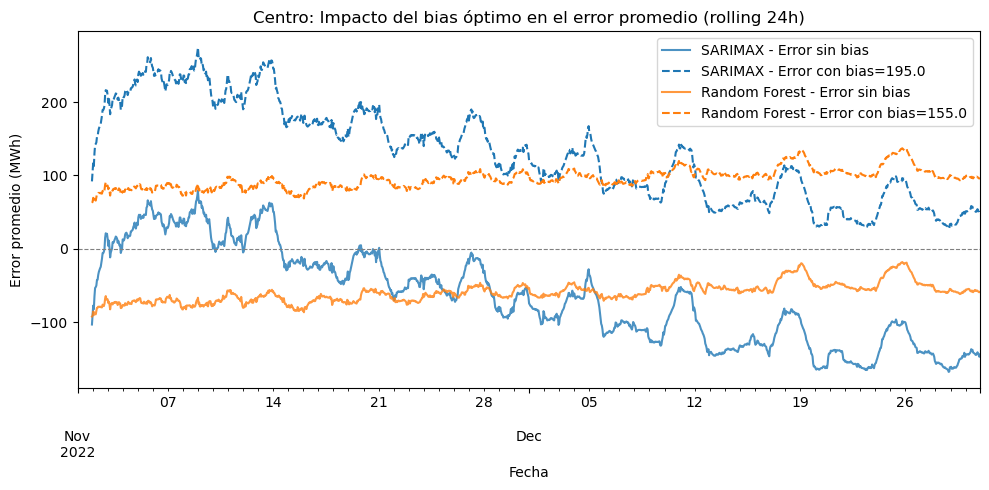

In [133]:
fig, ax = plt.subplots(figsize=(10, 5))

# --- Calcular errores promedio (rolling 24h) ---
err_sar_no_bias = (sar_common - y_common).rolling(24).mean()
err_sar_with_bias = ((sar_common + b_sar) - y_common).rolling(24).mean()

err_rf_no_bias = (rf_common - y_common).rolling(24).mean()
err_rf_with_bias = ((rf_common + b_rf) - y_common).rolling(24).mean()

# --- Graficar errores rolling ---
err_sar_no_bias.plot(ax=ax, label="SARIMAX - Error sin bias", color="tab:blue", alpha=0.8)
err_sar_with_bias.plot(ax=ax, label=f"SARIMAX - Error con bias={b_sar:.1f}", color="tab:blue", linestyle="--")

err_rf_no_bias.plot(ax=ax, label="Random Forest - Error sin bias", color="tab:orange", alpha=0.8)
err_rf_with_bias.plot(ax=ax, label=f"Random Forest - Error con bias={b_rf:.1f}", color="tab:orange", linestyle="--")

# --- Formato gráfico ---
ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
ax.set_title(f"{sr_ejemplo}: Impacto del bias óptimo en el error promedio (rolling 24h)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Error promedio (MWh)")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 💡 **Interpretación final:**

- Ajustar el *bias* del modelo es una forma práctica de **integrar el costo económico real** en el proceso de predicción.  
- Si el costo de **subestimar** la demanda es alto, conviene que el modelo **pronostique ligeramente por encima** de lo esperado para evitar pérdidas mayores.  
- Este ajuste no modifica la estructura del modelo base, sino que **mejora su calibración económica**, lo cual es especialmente valioso en la **gestión operativa del sector energético**.
